<a href="https://colab.research.google.com/github/nejdet/MachineLearning/blob/master/image_denoising_w_RNN/Image_Denoising_with_RNN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **IMAGE DENOISING WITH RECURRENT NEURAL NETWORKS**
Given notebook file will download 6 images from github repository. These images will be used to make list of 256x256 grayscale patches. 200 patches will be randomly selected from each images. 5 different copies of each patch will be created by adding Gaussian noise to each patch 5 times.

RNN network will try to clean noise from these patches. Noisy images will be our training set, and original images will be our target set.



#Libraries and Constants

In [0]:
from PIL import Image
import os, sys
import numpy as np
import matplotlib.pyplot as plt
from sklearn.feature_extraction import image
from sklearn.model_selection import train_test_split
from skimage.util import random_noise

from tensorflow import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, ConvLSTM2D
from tensorflow.keras.optimizers import Adam
from tensorflow.keras import backend as K
%matplotlib inline

In [0]:
# Model configuration
img_width, img_height = 256, 256
seq_length = 5
batch_size = 20
no_epochs = 10
verbosity = 1
number_of_visualizations = 2
patch_per_image = 200

# Importing Images from Github

In [0]:
import urllib.request
github_path = 'https://raw.githubusercontent.com/nejdet/MachineLearning/master/image_denoising_w_RNN/images/'
image_list = ['image1.jpg', 'image2.jpg', 'image3.jpg', 'image4.jpg', 'image5.jpg', 'image6.jpg']

images_dir = 'images'

if os.path.exists(images_dir) == False:
    os.mkdir(images_dir)

for fname in image_list:
    urllib.request.urlretrieve(github_path + fname, images_dir + '/' + fname)

# Creating Patches

In [0]:
path = "/content/images/"
dirs = os.listdir(path)
patches = []

for item in dirs:
    if os.path.isfile(path+item):
        img = Image.open(path+item)
        img = img.convert('L')
        img = np.asarray(img)
        img = img/255.0
        patches.extend(image.extract_patches_2d(img, (img_height, img_width), 
                                                    max_patches=patch_per_image, 
                                                    random_state=42))

### Creating Sequence with Gaussian Noise

In [0]:
noisy_sequence = []
row,col= patches[0].shape
mean = 0.0
var = 0.1

for patch in patches:
    sequence = []
    for i in range(5):
        noisy_image = random_noise(patch, mode='gaussian', clip=True, 
                           mean=mean, var=var)
        sequence.append(noisy_image)
    noisy_sequence.append(sequence)


# Splitting the dataset and reshaping inputs for Convolutinal Network

In [0]:
input_train, input_test, target_train, target_test = train_test_split(noisy_sequence, patches, test_size=0.2, random_state=42)

input_train = np.asarray(input_train)
input_test = np.asarray(input_test)
target_train = np.asarray(target_train)
target_test = np.asarray(target_test)

In [0]:
# Reshape data based on channels first / channels last strategy.
if K.image_data_format() == 'channels_first':
    input_train = input_train.reshape(input_train.shape[0], input_train.shape[1], 1, img_width, img_height)
    input_test = input_test.reshape(input_test.shape[0], input_test.shape[1], 1, img_width, img_height)
    target_train = target_train.reshape(target_train.shape[0], 1, img_width, img_height)
    target_test = target_test.reshape(target_test.shape[0], 1, img_width, img_height)
    input_shape = (input_train.shape[1], 1, img_width, img_height)
else:
    input_train = input_train.reshape(input_train.shape[0], input_train.shape[1], img_width, img_height, 1)
    input_test = input_test.reshape(input_test.shape[0], input_test.shape[1], img_width, img_height, 1)
    target_train = target_train.reshape(target_train.shape[0], img_width, img_height, 1)
    target_test = target_test.reshape(target_test.shape[0], img_width, img_height, 1)
    input_shape = (input_train.shape[1], img_width, img_height, 1)


#Create and Compile the Model

In [15]:
# Create the model
model = Sequential()

model.add(ConvLSTM2D(16, kernel_size=(3, 3), activation='relu', padding='same', input_shape=input_shape, return_sequences=False))
model.add(Conv2D(1, kernel_size=(3, 3), activation='sigmoid', padding='same'))

model.summary()

# Compile Model
model.compile(optimizer=Adam(learning_rate=0.001), loss='binary_crossentropy')

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv_lst_m2d (ConvLSTM2D)    (None, 256, 256, 16)      9856      
_________________________________________________________________
conv2d (Conv2D)              (None, 256, 256, 1)       145       
Total params: 10,001
Trainable params: 10,001
Non-trainable params: 0
_________________________________________________________________


# Fit the Model to Dataset

In [16]:
history = model.fit(input_train, target_train,
                epochs=no_epochs,
                batch_size=batch_size,
                validation_data=(input_test, target_test))


Epoch 1/10
48/48 [==============================] - 22s 460ms/step - loss: 0.6391 - val_loss: 0.5828
Epoch 2/10
48/48 [==============================] - 22s 452ms/step - loss: 0.5206 - val_loss: 0.5112
Epoch 3/10
48/48 [==============================] - 22s 452ms/step - loss: 0.4909 - val_loss: 0.4967
Epoch 4/10
48/48 [==============================] - 22s 451ms/step - loss: 0.4870 - val_loss: 0.4952
Epoch 5/10
48/48 [==============================] - 22s 451ms/step - loss: 0.4856 - val_loss: 0.4943
Epoch 6/10
48/48 [==============================] - 22s 452ms/step - loss: 0.4847 - val_loss: 0.4940
Epoch 7/10
48/48 [==============================] - 22s 452ms/step - loss: 0.4845 - val_loss: 0.4940
Epoch 8/10
48/48 [==============================] - 22s 452ms/step - loss: 0.4846 - val_loss: 0.4945
Epoch 9/10
48/48 [==============================] - 22s 453ms/step - loss: 0.4843 - val_loss: 0.4936
Epoch 10/10
48/48 [==============================] - 22s 452ms/step - loss: 0.4841 - val_lo

#Plot the Loss

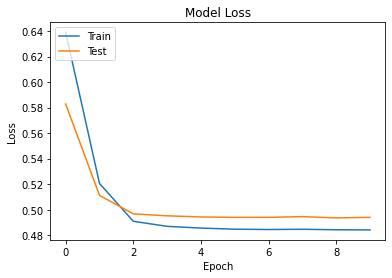

In [17]:
# Plot training & validation loss values
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

# Output - Input comparison

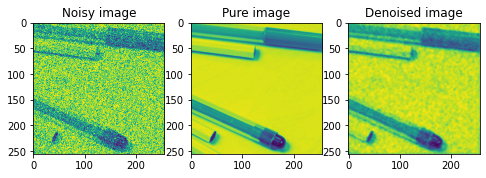

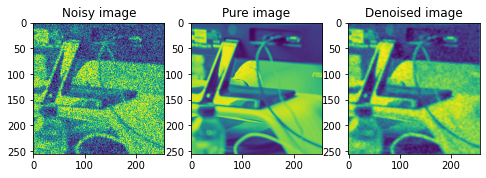

In [18]:
# Generate denoised images
samples = input_test[:number_of_visualizations]
targets = target_test[:number_of_visualizations]
denoised_images = model.predict(samples)

# Plot denoised images
for i in range(0, number_of_visualizations):
  # Get the sample and the reconstruction
  noisy_image = input_test[i,0][:, :, 0]
  pure_image  = target_test[i][:, :, 0]
  denoised_image = denoised_images[i][:, :, 0]
  input_class = targets[i]
  # Matplotlib preparations
  fig, axes = plt.subplots(1, 3)
  fig.set_size_inches(8, 3.5)
  # Plot sample and reconstruciton
  axes[0].imshow(noisy_image)
  axes[0].set_title('Noisy image')
  axes[1].imshow(pure_image)
  axes[1].set_title('Pure image')
  axes[2].imshow(denoised_image)
  axes[2].set_title('Denoised image')
  plt.show()
